# SENTIMETION CLASSIFICATION WITH UIT-VSFC DATASET

In [2]:
!pip install py_vncorenlp

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.6 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4307 sha256=f6d2fb309a1f5f2b1568dd5ecdec4dffbc945270b70482de4987274c33315f2b
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


## Importing the libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import py_vncorenlp
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from tqdm import tqdm
import time


## Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
X_train = pd.read_csv('/content/drive/MyDrive/CV/Sentiment-Analysis-Student-Feedback/Datasets/train/feedback.txt', sep=' \n', engine='python', header=None, names=['feedback'])
y_train =  pd.read_csv('/content/drive/MyDrive/CV/Sentiment-Analysis-Student-Feedback/Datasets/train/label.txt', sep=" \n", engine='python', header=None, names=['label'])

X_test = pd.read_csv('/content/drive/MyDrive/CV/Sentiment-Analysis-Student-Feedback/Datasets/test/feedback.txt', sep=' \n', engine='python', header=None, names=['feedback'])
y_test =  pd.read_csv('/content/drive/MyDrive/CV/Sentiment-Analysis-Student-Feedback/Datasets/test/label.txt', sep=" \n", engine='python', header=None, names=['label'])


### Preview dataset

In [6]:
X_train

,feedback
0,slide giáo trình đầy đủ .
1,"nhiệt tình giảng dạy , gần gũi với sinh viên ."
2,đi học đầy đủ full điểm chuyên cần .
3,chưa áp dụng công nghệ thông tin và các thiết ...
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng..."
...,...
13004,hướng dẫn lab mơ hồ .
13005,thầy cho chúng em những bài tập mang tính thực...
13006,thầy không dạy nhiều chủ yếu cho sinh viên tự ...
13007,em muốn đổi tên môn học vì tên môn là lập trìn...


In [7]:
y_train.value_counts()

label
2        6448
0        6030
1         531
dtype: int64

In [8]:
y_test.value_counts()

label
2        1590
0        1409
1         167
dtype: int64

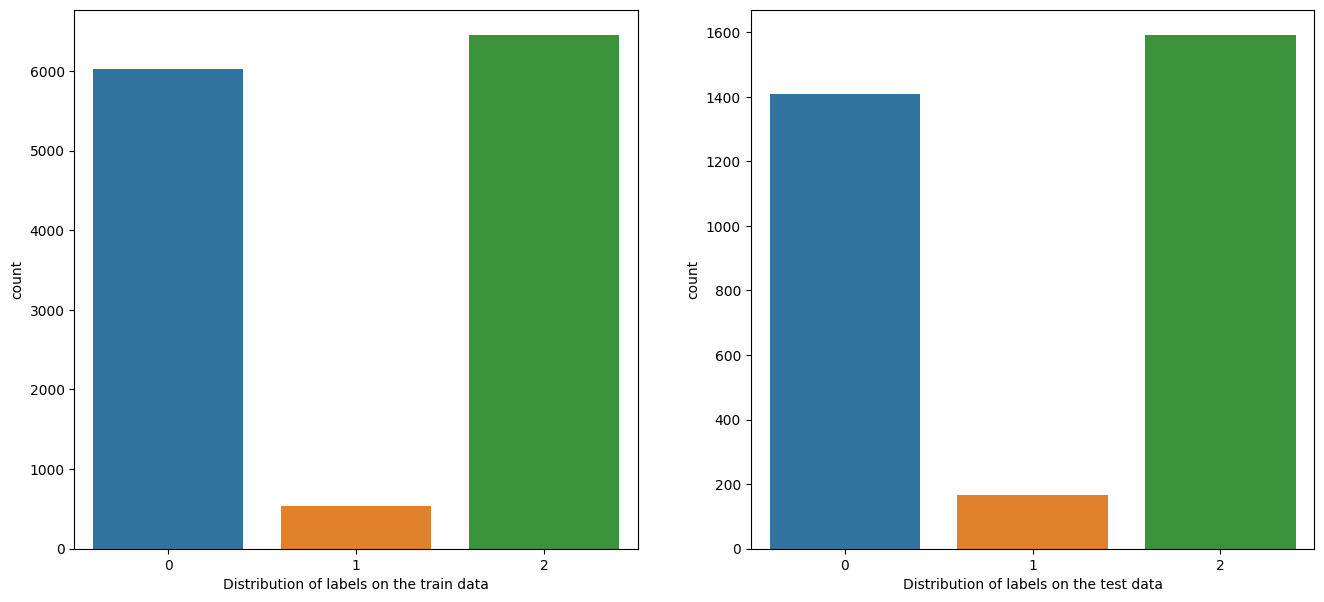

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
sns.countplot(data=y_train, x='label', ax=ax1)
sns.countplot(data=y_test, x='label', ax=ax2)
ax1.set_xlabel('Distribution of labels on the train data')
ax2.set_xlabel('Distribution of labels on the test data')
plt.show()

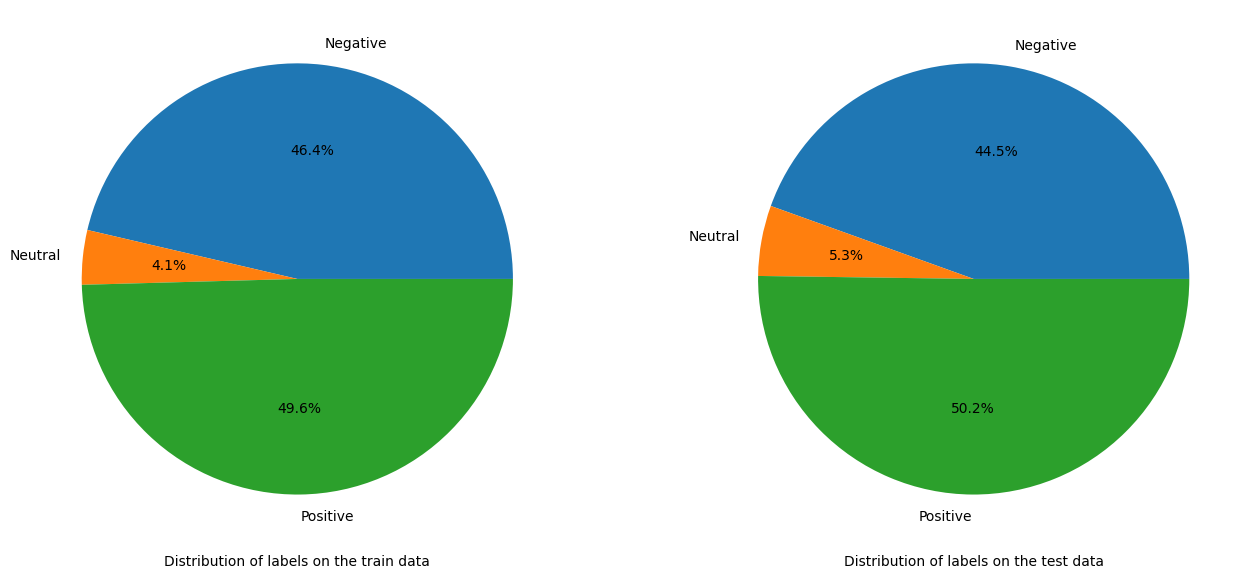

In [10]:
labels = ['Negative', 'Neutral', 'Positive']
data1 = y_train.value_counts(sort=False)
data2 = y_test.value_counts(sort=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
ax1.pie(data1, labels = labels, autopct='%1.1f%%')
ax2.pie(data2, labels = labels, autopct='%1.1f%%')
ax1.set_xlabel('Distribution of labels on the train data')
ax2.set_xlabel('Distribution of labels on the test data')
plt.show()

## Preprocessing

In [11]:
import re

wordsegment = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/drive/MyDrive/CV/Sentiment-Analysis-Student-Feedback/wordsegmenter')
def Preprocessing(feedback):
    # xóa ký tự kéo dài
    feedback = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), feedback, flags=re.I)

    # chuẩn hóa chữ thường
    feedback = feedback.lower()

    # xóa ký hiệu teencode
    icons = [':)', ':(', '@@', '<3', ':d', ':3', ':v', ':_', ':p', '>>', ':">', '^^', 'v.v', ':B', ':^', ':v', 'y_y', 'u_u']
    for icon in icons:
        feedback = feedback.replace(icon,' ')

    # xóa từ viết tắt mà tác giả đã biến đổi
    acronyms = ['colon', 'smile', 'sad', 'surprise', 'love', 'contemn', 'big', 'smile', 'cc',
                'small', 'hihi', 'double', 'vdotv','dot', 'fraction', 'csharp']
    for acronym in acronyms:
        feedback = feedback.replace(acronym, ' ')

    # xóa ký tự đặc biệt
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for punc in punctuation:
        feedback = feedback.replace(punc,' ')

    # word_segment
    feedback = ''.join(wordsegment.word_segment(feedback))

    return feedback

In [12]:
for i in tqdm(range(len(X_train['feedback']))):
    X_train['feedback'][i] = Preprocessing(X_train['feedback'][i])

100%|██████████| 13009/13009 [00:40<00:00, 321.34it/s]


In [13]:
for i in tqdm(range(len(X_test['feedback']))):
    X_test['feedback'][i] = Preprocessing(X_test['feedback'][i])

100%|██████████| 3166/3166 [00:06<00:00, 495.43it/s]


In [14]:
X_train

,feedback
0,slide giáo_trình đầy_đủ
1,nhiệt_tình giảng_dạy gần_gũi với sinh_viên
2,đi học đầy_đủ ful điểm chuyên_cần
3,chưa áp_dụng công_nghệ_thông_tin và các thiết_...
4,thầy giảng bài hay có nhiều bài_tập ví_dụ ngay...
...,...
13004,hướng_dẫn lab mơ_hồ
13005,thầy cho chúng_em những bài_tập mang tính thực...
13006,thầy không dạy nhiều chủ_yếu cho sinh_viên tự ...
13007,em muốn đổi tên môn_học vì tên môn là lập_trìn...


In [15]:
y_train

,label
0,2
1,2
2,0
3,0
4,2
...,...
13004,0
13005,2
13006,0
13007,0


# TfidfVectorizer

In [16]:
tfidf = TfidfVectorizer(ngram_range=(1,1), use_idf=False, norm=None, sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train['feedback'])
X_test_tfidf= tfidf.transform(X_test['feedback'])

y_train_tfidf = y_train['label']
y_test_tfidf = y_test['label']

In [17]:
print(len(tfidf.get_feature_names_out()))

3777


# SMOTE tăng cường dữ liệu tập train

In [18]:
from imblearn.over_sampling import BorderlineSMOTE
smote = BorderlineSMOTE(k_neighbors=7, random_state=42, kind='borderline-2')
X_train_tfidf, y_train_tfidf = smote.fit_resample(X_train_tfidf, y_train_tfidf)

In [44]:
metrics = []

# Naive Bayes Model

In [45]:
NB_model = MultinomialNB(alpha=10)
NB_model.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = NB_model.predict(X_test_tfidf)

print(classification_report(y_test_tfidf, y_pred_tfidf, digits=4))
precision = precision_score(y_test_tfidf, y_pred_tfidf, average='macro')
recall = recall_score(y_test_tfidf, y_pred_tfidf, average='macro')
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='macro')
metrics.append([precision, recall, f1])

              precision    recall  f1-score   support

           0     0.8194    0.9013    0.8584      1409
           1     0.3068    0.3234    0.3149       167
           2     0.9250    0.8377    0.8792      1590

    accuracy                         0.8389      3166
   macro avg     0.6837    0.6875    0.6842      3166
weighted avg     0.8454    0.8389    0.8402      3166



# Logistic Regression

In [46]:
LR_model = LogisticRegression(multi_class='multinomial', C=10, penalty='l2', solver='lbfgs', max_iter=1000, random_state=42, tol=0.5)
LR_model.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = LR_model.predict(X_test_tfidf)

print(classification_report(y_test_tfidf, y_pred_tfidf, digits=4))
precision = precision_score(y_test_tfidf, y_pred_tfidf, average='macro')
recall = recall_score(y_test_tfidf, y_pred_tfidf, average='macro')
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='macro')
metrics.append([precision, recall, f1])

              precision    recall  f1-score   support

           0     0.8947    0.8566    0.8753      1409
           1     0.2788    0.5210    0.3633       167
           2     0.9282    0.8786    0.9027      1590

    accuracy                         0.8500      3166
   macro avg     0.7006    0.7521    0.7138      3166
weighted avg     0.8791    0.8500    0.8621      3166



# XG_Boost Model

In [47]:
XGB_model = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
XGB_model.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = XGB_model.predict(X_test_tfidf)

print(classification_report(y_test_tfidf, y_pred_tfidf, digits=4))
precision = precision_score(y_test_tfidf, y_pred_tfidf, average='macro')
recall = recall_score(y_test_tfidf, y_pred_tfidf, average='macro')
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='macro')
metrics.append([precision, recall, f1])

              precision    recall  f1-score   support

           0     0.8895    0.9255    0.9071      1409
           1     0.4365    0.3293    0.3754       167
           2     0.9123    0.9031    0.9077      1590

    accuracy                         0.8828      3166
   macro avg     0.7461    0.7193    0.7301      3166
weighted avg     0.8771    0.8828    0.8794      3166



# SVM Model

In [48]:
# SVM Model use Countvectorizer
SVM_model = SVC(C=10, gamma=0.1, kernel='rbf', random_state=42)
SVM_model.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = SVM_model.predict(X_test_tfidf)

print(classification_report(y_test_tfidf, y_pred_tfidf, digits=4))
precision = precision_score(y_test_tfidf, y_pred_tfidf, average='macro')
recall = recall_score(y_test_tfidf, y_pred_tfidf, average='macro')
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='macro')
metrics.append([precision, recall, f1])

              precision    recall  f1-score   support

           0     0.8829    0.9468    0.9137      1409
           1     0.5147    0.4192    0.4620       167
           2     0.9388    0.8969    0.9173      1590

    accuracy                         0.8939      3166
   macro avg     0.7788    0.7543    0.7644      3166
weighted avg     0.8915    0.8939    0.8917      3166



In [49]:
pd.DataFrame(metrics, columns=['Precision', 'Recall', 'F1-score'], index=['Naive Bayes', 'Extreme Gradient Boosting', 'Logistic Regression', 'Support Vector Machine'])

,Precision,Recall,F1-score
Naive Bayes,0.683724,0.687479,0.684158
Extreme Gradient Boosting,0.700607,0.752070,0.713758
Logistic Regression,0.746109,0.719322,0.730090
Support Vector Machine,0.778780,0.754263,0.764361


In [50]:
from sklearn.ensemble import VotingClassifier
SVM_model.probability=True
total = np.sum([metrics[i][-1] for i in [1,2,3]])
weights = [metrics[i][-1] / total for i in [1,2,3]]

voting_clf = VotingClassifier(estimators=[('xgb',XGB_model), ('lr',LR_model), ('svm',SVM_model)], voting='soft', weights=weights)
voting_clf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = voting_clf.predict(X_test_tfidf)

print(classification_report(y_test_tfidf, y_pred_tfidf, digits=4))
precision = precision_score(y_test_tfidf, y_pred_tfidf, average='macro')
recall = recall_score(y_test_tfidf, y_pred_tfidf, average='macro')
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='macro')
metrics.append([precision, recall, f1])

              precision    recall  f1-score   support

           0     0.8992    0.9432    0.9207      1409
           1     0.4932    0.4311    0.4601       167
           2     0.9371    0.9088    0.9227      1590

    accuracy                         0.8989      3166
   macro avg     0.7765    0.7611    0.7678      3166
weighted avg     0.8968    0.8989    0.8974      3166



In [51]:
pd.DataFrame(metrics, columns=['Precision', 'Recall', 'F1-score'], index=['Naive Bayes', 'Extreme Gradient Boosting', 'Logistic Regression', 'Support Vector Machine', 'VotingClassifier'])

,Precision,Recall,F1-score
Naive Bayes,0.683724,0.687479,0.684158
Extreme Gradient Boosting,0.700607,0.752070,0.713758
Logistic Regression,0.746109,0.719322,0.730090
Support Vector Machine,0.778780,0.754263,0.764361
VotingClassifier,0.776478,0.761055,0.767825


In [52]:
print(len(tfidf.get_feature_names_out()))

3777


In [53]:
import joblib
joblib.dump((voting_clf, tfidf), '/content/drive/MyDrive/CV/Sentiment-Analysis-Student-Feedback/model.h5')

['/content/drive/MyDrive/CV/Sentiment-Analysis-Student-Feedback/model.h5']